In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
import pynini

from torch.utils.data import DataLoader
from model_util import SequenceDataset, DistilBertData

import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

PROBLEM = "04.03.TSL.2.1.8" # "04.04.SL.2.1.8" # "16.16.SL.2.1.9"
MAX_STRING_LENGTH = 29 # must be same as in training script

DO_TSNE = False 

DATASET_CONTAINER_PATH = "dataset_problem_{}.pk".format(PROBLEM) # where to save dataset metadata 
RESULTS_PATH = "../trained_models/"

TRAIN_DATA_PATH = "../data/abbadingo/Mid/{}_Train.txt.dat".format(PROBLEM)
TEST_DATA_PATH = "../data/abbadingo/Mid/{}_TestSR.txt.dat".format(PROBLEM)

FST_PATH = "../data/languages/fst"

/home/robert/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = SequenceDataset(TRAIN_DATA_PATH, maxlen=MAX_STRING_LENGTH)
train_dataset.initialize(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))
train_dataset.encode_sequences()

del train_dataset.one_hot_seq
del train_dataset.one_hot_seq_sr
del train_dataset.ordinal_seq_sr

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'd', 'c', 'b', 'd', 'c', 'a', 'c', 'd', 'd', 'b', 'a', 'b'], ['a', 'a', 'a', 'a', 'a', 'd', 'b', 'b', 'd', 'a', 'd', 'a', 'a', 'b', 'd', 'a', 'b', 'a', 'd', 'b'], ['a', 'a', 'a', 'a', 'b', 'c', 'b', 'a', 'd', 'c', 'b', 'a', 'c', 'a', 'c', 'd', 'c', 'd', 'c', 'd']]
The symbol dictionary: {'a': 0, 'd': 1, 'c': 2, 'b': 3}


## Get the model

In [3]:
def make_dict(**kwargs):
    return kwargs

model = torch.load(os.path.join("..", "trained_models", "model_{}.pk".format(PROBLEM)))

## Get the state machine

In [4]:
the_fsa = pynini.Fst.read(os.path.join(FST_PATH, "{}.fst".format(PROBLEM)))
states = [q for q in the_fsa.states()]
initial_state = the_fsa.start()
initial_state, states

(0, [0, 1, 2])

In [5]:
symbol_to_char = dict(the_fsa.input_symbols())
char_to_symbol = {v: k for k, v in symbol_to_char.items()}

char_to_symbol

{'<EPS>': 0, 'a': 97, 'b': 98, 'c': 99, 'd': 100}

In [6]:
arcs = {q: {symbol_to_char[a.ilabel]: a.nextstate for a in the_fsa.arcs(q)} for q in states}
arcs

{0: {'d': 0, 'a': 1},
 1: {'b': 2, 'c': 2, 'a': 1, 'd': 1},
 2: {'b': 2, 'c': 2, 'd': 2, 'a': 1}}

## Get test attentions and outputs

In [7]:
def construct_attn_mask(lengths, maxlen):
    """
    Lengths is a list. For each sequence in input_ids it gives the length
    """
    res = torch.ones((len(lengths), maxlen))
    for i, l in enumerate(lengths):
        res[i, l:] = 0
    return res

def get_forward_dict(x, y, mask, output_attentions=False):
    forward_dict = make_dict(
        input_ids=x, # the training data
        labels=y, # the training labels
        attention_mask=mask, # TODO: we can do this to improve the models I suppose
        head_mask=None,
        output_attentions=output_attentions,
        output_hidden_states=False,
        return_dict=True,
    )
    return forward_dict

In [8]:
test_dataset = SequenceDataset(TEST_DATA_PATH, maxlen=MAX_STRING_LENGTH)
test_dataset.initialize(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))
test_dataset.encode_sequences()

del test_dataset.one_hot_seq
del test_dataset.one_hot_seq_sr
del test_dataset.ordinal_seq_sr

test_input_ids = torch.cat(list(torch.unsqueeze(x, 0) for x in test_dataset.ordinal_seq))
test_labels = test_dataset.labels

test_attn_mask = construct_attn_mask(test_dataset.sequence_lengths, test_dataset.maxlen)

test_res = model(**get_forward_dict(test_input_ids, None, test_attn_mask, output_attentions=True))
test_predictions = np.array(torch.argmax(test_res.logits, dim=1))
test_attn = test_res.attentions[0].detach().numpy()
test_predictions.shape, np.unique(test_predictions, return_counts=True), test_attn.shape

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'a', 'a', 'a', 'a', 'd', 'c', 'a', 'd', 'a', 'd', 'c', 'b', 'a', 'c', 'a', 'd', 'c'], ['a', 'a', 'a', 'a', 'a', 'd', 'c', 'c', 'a', 'd', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'b', 'd', 'd'], ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'a', 'b', 'c', 'b', 'd', 'd', 'a', 'd', 'c', 'b', 'b', 'b', 'd']]
The symbol dictionary: {'a': 0, 'd': 1, 'c': 2, 'b': 3}


((10000,), (array([0, 1]), array([5778, 4222])), (10000, 4, 31, 31))

## Get the sequence of states for each sequence

In [9]:
def convert_ids_to_chars(mapping, tensor_1d, eos_symbol: int = None):
    """
    Converts the input_ids tensor to a list representing the original input.
    Mapping is dict mapping int to str/char.

    tensor_1d: The sequence as provided to the model.
    """
    res = list()
    eos_idx = None
    try:
        tensor_1d = tensor_1d.detach().numpy()
    except:
        tensor_1d = tensor_1d.numpy()
    for i, x in enumerate(tensor_1d):
        if eos_symbol is not None and x==eos_symbol:
            eos_idx = i
        res.append(mapping[x])
    print("The original sequence: {}".format(" ".join(res)))
    return res, eos_idx

symbol_dict = {k: v for k, v in test_dataset.symbol_dict.items()}
symbol_dict["<SOS>"] = train_dataset.SOS
symbol_dict["<EOS>"] = train_dataset.EOS
symbol_dict["<PAD>"] = train_dataset.PAD

symbol_dict

{'a': 0, 'd': 1, 'c': 2, 'b': 3, '<SOS>': 4, '<EOS>': 5, '<PAD>': 6}

In [10]:
int_to_char_map = {v: k for k, v in symbol_dict.items()}

def map_to_chars(sequences, int_to_char_map):
    res = list()
    for i, seq in enumerate(sequences):
        sequence = list()
        for j, s in enumerate(seq):
            sequence.append(int_to_char_map[s])
        res.append(sequence)
    return res

char_sequences = map_to_chars(test_input_ids.detach().numpy(), int_to_char_map)
char_sequences[0]

['<SOS>',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'd',
 'c',
 'a',
 'd',
 'a',
 'd',
 'c',
 'b',
 'a',
 'c',
 'a',
 'd',
 'c',
 '<EOS>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [11]:
def extract_state_sequences(char_sequences, initial_state, arcs):
    """
    Char sequences is list of list. Returns a list of lists containing 
    state reached after each outgoing symbol.
    """
    res = list()
    for sequence in char_sequences:
        q = None
        trace = list()
        for symbol in sequence:
            if symbol=="<SOS>":
                q = initial_state
            elif symbol=="<EOS>":
                q = -1 # we are interested in this embedding, too
            elif symbol=="<PAD>":
                break
            elif q==-2: # we are in the sink state
                q = -2
            elif symbol not in arcs[q]:
                q = -2 # automaton cannot be parsed, hence trace not accepting, hence we are in sink state
            else:
                q = arcs[q][symbol]
            trace.append(q)
        res.append(trace)
    return res

state_sequences = extract_state_sequences(char_sequences, initial_state, arcs)
state_sequences[:5], char_sequences[:5]

([[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, -1],
  [0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1],
  [0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, -1],
  [0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, -1],
  [0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, -1]],
 [['<SOS>',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'd',
   'c',
   'a',
   'd',
   'a',
   'd',
   'c',
   'b',
   'a',
   'c',
   'a',
   'd',
   'c',
   '<EOS>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>'],
  ['<SOS>',
   'a',
   'a',
   'a',
   'a',
   'a',
   'd',
   'c',
   'c',
   'a',
   'd',
   'd',
   'c',
   'b',
   'c',
   'b',
   'c',
   'd',
   'b',
   'd',
   'd',
   '<EOS>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>'],
  ['<SOS>',
   'a',
   'a',
   'a',
   'a',
   'b',
   'b'

## Map the sequences of states along with the embeddings, check if you get meaningful output here

In [12]:
def filter_attention(sequences, attentions, lengths, state_sequences):
    """
    Gets the attention etc. into a good shape. We discard everything padded here.

    sequences: np.array
    attentions: np.array
    lengths: list with the lengths.
    states: A list of states visited. In accordance with sequences
    """
    attn_stack = None
    symbols = list()
    visited_states = list()
    
    for attn, seq, l, state_s in zip(attentions, sequences, lengths, state_sequences):
        if len(attn.shape) > 2:            
            # we have multiple heads
            attn = np.mean(attn, axis=0) # (seq_length, seq_length)
        attn = attn[:l]
        attn_stack = attn if attn_stack is None else np.vstack((attn_stack, attn))

        seq = list(seq[:l])
        #print(seq)
        symbols.extend(seq)
        qs = list(state_s[:l])
        visited_states.extend(qs)

    return attn_stack, symbols, visited_states

In [13]:
attn_filtered, symbols_filtered, states_filtered = filter_attention(
                                                               test_input_ids.detach().numpy(), 
                                                               test_attn,
                                                               list(np.array(test_dataset.sequence_lengths)),
                                                               state_sequences
                                                               )

In [14]:
attn_filtered.shape, len(symbols_filtered), len(states_filtered)

((265000, 31), 265000, 265000)

<Axes: >

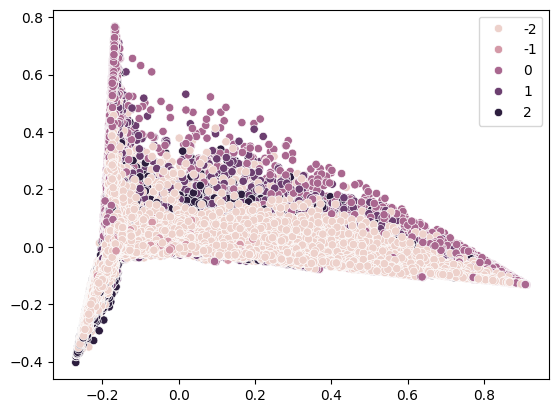

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered)
sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered))

## Look at only stuff that you care about

In [16]:
no_eos_idxs = np.where(np.array(states_filtered)!=-1)[0]
no_sink_state_idxs = np.where(np.array(states_filtered)!=-2)[0]

idxs_under_investigation = list(set(list(no_eos_idxs)).intersection(set(list(no_sink_state_idxs))))

<Axes: >

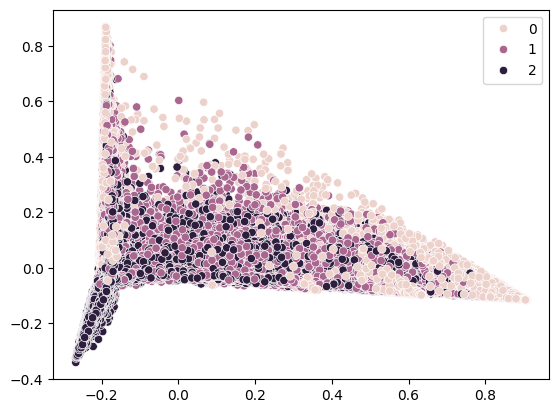

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

In [18]:
if DO_TSNE:
    from sklearn.manifold import TSNE
    
    tsne = TSNE()
    attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])

In [19]:
if DO_TSNE:
    states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
    zero_idx = np.where(states_under_investigation==0)[0]
    one_idx = np.where(states_under_investigation==1)[0]
    two_idx = np.where(states_under_investigation==2)[0]
    
    sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=states_under_investigation[one_idx], palette="rocket")
    sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=states_under_investigation[zero_idx], palette="mako")
    sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=states_under_investigation[two_idx])

from sklearn.manifold import TSNE

tsne = TSNE()
attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

## What about when we only look at positive predicted strings?

In [20]:
POSITIVE_LABEL = train_dataset.label_dict["A"]
NEGATIVE_LABEL = train_dataset.label_dict["R"]

positive_prediction_idxs = np.where(test_predictions==POSITIVE_LABEL)[0]
positive_label_idxs = np.where(np.array(test_labels)==POSITIVE_LABEL)[0]

positive_prediction_idxs

array([   0,    1,    2, ..., 9996, 9997, 9998])

In [21]:
attn_filtered, symbols_filtered, states_filtered = filter_attention(
                                                               test_input_ids[positive_prediction_idxs].detach().numpy(), 
                                                               test_attn[positive_prediction_idxs],
                                                               list(np.array(test_dataset.sequence_lengths)[positive_prediction_idxs]),
                                                               [state_sequences[i] for i in positive_prediction_idxs]
                                                               )

In [22]:
attn_filtered.shape, len(symbols_filtered), len(states_filtered)

((153220, 31), 153220, 153220)

In [23]:
no_eos_idxs = np.where(np.array(states_filtered)!=-1)[0]
no_sink_state_idxs = np.where(np.array(states_filtered)!=-2)[0]

idxs_under_investigation = list(set(list(no_eos_idxs)).intersection(set(list(no_sink_state_idxs))))

<Axes: >

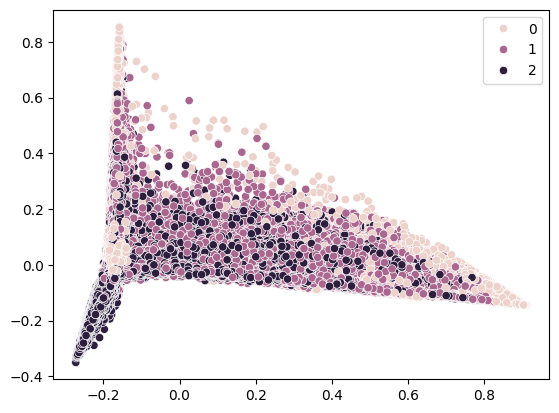

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

<Axes: >

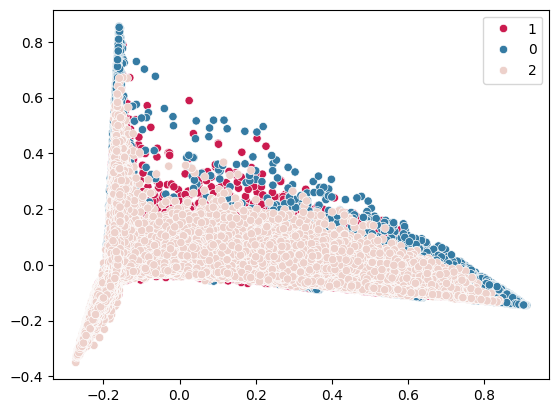

In [25]:
states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
zero_idx = np.where(np.array(states_under_investigation)==0)[0]
one_idx = np.where(np.array(states_under_investigation)==1)[0]
two_idx = np.where(np.array(states_under_investigation)==2)[0]
    
sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=np.array(states_under_investigation)[one_idx], palette="rocket")
sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=np.array(states_under_investigation)[zero_idx], palette="mako")
sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=np.array(states_under_investigation)[two_idx])

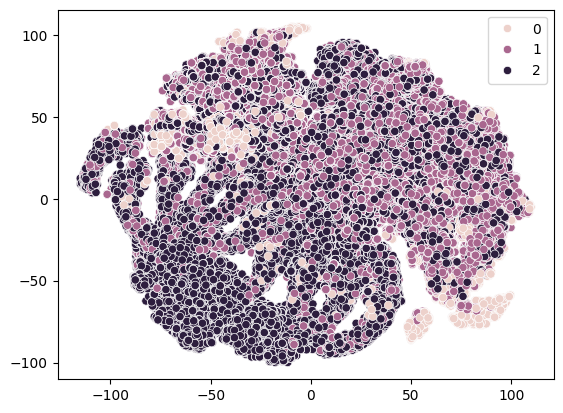

In [26]:
DO_TSNE = True

if DO_TSNE:
    from sklearn.manifold import TSNE
    tsne = TSNE()
    attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])
    
    sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

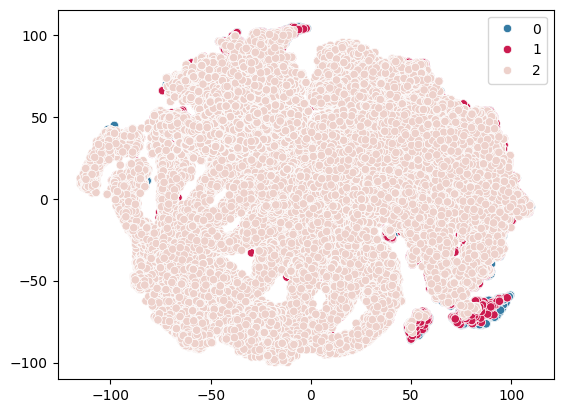

In [27]:
if DO_TSNE:
    states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
    zero_idx = np.where(np.array(states_under_investigation)==0)[0]
    one_idx = np.where(np.array(states_under_investigation)==1)[0]
    two_idx = np.where(np.array(states_under_investigation)==2)[0]
    
    sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=np.array(states_under_investigation)[zero_idx], palette="mako")
    sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=np.array(states_under_investigation)[one_idx], palette="rocket")
    sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=np.array(states_under_investigation)[two_idx])
